In [2]:
!pip install pytorch_lightning -qq
!pip install --upgrade wandb -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 715.6/715.6 KB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.1/189.1 KB 18.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 6.5 MB/s eta 0:00:00


In [3]:
import pytorch_lightning as pl

In [4]:
import os
import torch
from torch import nn, optim, utils
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [5]:
class Fashion_MNIST_Classifier(pl.LightningModule):
    def __init__(self, n_hidden_neurons):
        super(Fashion_MNIST_Classifier, self).__init__()
        self.fc1 = nn.Linear(in_features=28*28, out_features=128)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.act2 = nn.ReLU()
        self.output = nn.Linear(64, 10)
        self.sm = nn.LogSoftmax(dim=1)

    def forward(self, x):
        batch_size, channels, width, height = x.size()
        x = x.view(batch_size, -1)
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.output(x)
        x = self.sm(x)
        return x


    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        x, y = batch
        logits = self.forward(x)
        loss = F.nll_loss(logits, y)
        acc = (logits.argmax(dim=1) == y).sum()*1.0 / len(y)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('accuracy', acc)
        # Logging to TensorBoard (if installed) by default
        return {'loss':loss}


    def validation_step(self, batch, batch_idx):
      # training_step defines the train loop.
        # it is independent of forward
        x, y = batch
        logits = self.forward(x)
        loss = F.nll_loss(logits, y)
        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        # Logging to TensorBoard (if installed) by default
        return {'loss':loss}  

    def test_step(self, batch, batch_idx):
        # this is the test loop
        x, y = batch
        logits = self.forward(x)
        loss = F.nll_loss(logits, y)
        self.log("test_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return {'loss': loss}

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, y = batch
        y_hat = self.forward(x)
        return y_hat

    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer





In [6]:
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir: str = "path/to/dir", batch_size: int = 32):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

    def prepare_data(self):
        # download
        FashionMNIST(self.data_dir, train=True, download=True)
        FashionMNIST(self.data_dir, train=False, download=True)


    def setup(self, stage: str):
        # Assign train/val datasets for use in dataloaders
        if stage == "fit":
            mnist_full = FashionMNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        # Assign test dataset for use in dataloader(s)
        if stage == "test":
            self.mnist_test = FashionMNIST(self.data_dir, train=False, transform=self.transform)

        if stage == "predict":
            self.mnist_predict = FashionMNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size)

    def predict_dataloader(self):
        return DataLoader(self.mnist_predict, batch_size=self.batch_size)

    

In [7]:
model = Fashion_MNIST_Classifier(30)
trainer = pl.Trainer()


/usr/local/lib/python3.9/dist-packages/lightning_fabric/accelerators/cuda.py:235: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [8]:
data_model = MNISTDataModule(os.getcwd())


In [9]:
dataset = FashionMNIST(os.getcwd(), download=True, transform=ToTensor())
train_loader = utils.data.DataLoader(dataset)


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /content/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /content/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /content/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /content/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/FashionMNIST/raw



In [10]:
trainer = pl.Trainer(limit_train_batches=100, max_epochs=20)
trainer.fit(model, data_model)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type       | Params
--------------------------------------
0 | fc1    | Linear     | 100 K 
1 | act1   | ReLU       | 0     
2 | fc2    | Linear     | 8.3 K 
3 | act2   | ReLU       | 0     
4 | output | Linear     | 650   
5 | sm     | LogSoftmax | 0     
--------------------------------------
109 K     Trainable params
0         Non-trainable params
109 K     Total params
0.438     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [11]:
trainer.test(model=model, datamodule=data_model)

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch        0.5865187048912048
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss_epoch': 0.5865187048912048}]

In [12]:
trainer.validate(model=model, datamodule=data_model)

Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     val_loss_epoch         0.5489747524261475
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss_epoch': 0.5489747524261475}]

In [13]:
trainer.test(model=model, datamodule=data_model)

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch        0.5865187048912048
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss_epoch': 0.5865187048912048}]

In [26]:
predictions = trainer.predict(model=model, datamodule=data_model)

Predicting: 0it [00:00, ?it/s]

In [15]:
proba = torch.exp(predictions[0])


In [16]:
_, pred_labels = proba.topk(1, dim=1)
print(pred_labels)

tensor([[9],
        [2],
        [1],
        [1],
        [6],
        [1],
        [4],
        [6],
        [5],
        [7],
        [4],
        [5],
        [5],
        [3],
        [4],
        [1],
        [2],
        [2],
        [8],
        [0],
        [2],
        [5],
        [7],
        [7],
        [1],
        [2],
        [6],
        [0],
        [9],
        [3],
        [8],
        [3]])


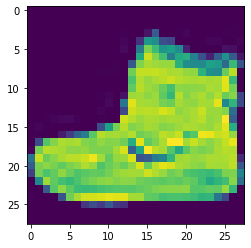

tensor(7)


In [24]:
plt.imshow(dataset.test_data[0, :, :])
plt.show()
print(dataset.test_labels[6])

In [18]:
(predictions.argmax(dim=1) == dataset.test_labels).float().mean()

AttributeError: ignored

In [ ]:
dataset.test_labels[0]